<a href="https://colab.research.google.com/github/danieldalton13/optimisation_top_Y1/blob/main/04_10_24_optimisation_algorithm_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GA algorithm tuning to search the space better

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             6.236413      Tension        
Member 2     2             3             6.236413      Tension        
Member 3     3             4             18.070652     Tension        
Member 4     4             5             18.070652     Tension        
Member 5     5             6             6.236413      Tension        
Member 6     6             7             6.236413      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            5.461957      Tension        
Member 9     10            11            5.461957      Tension        
Member 10    11            12            5.461957      Tension        
Member 11    12      

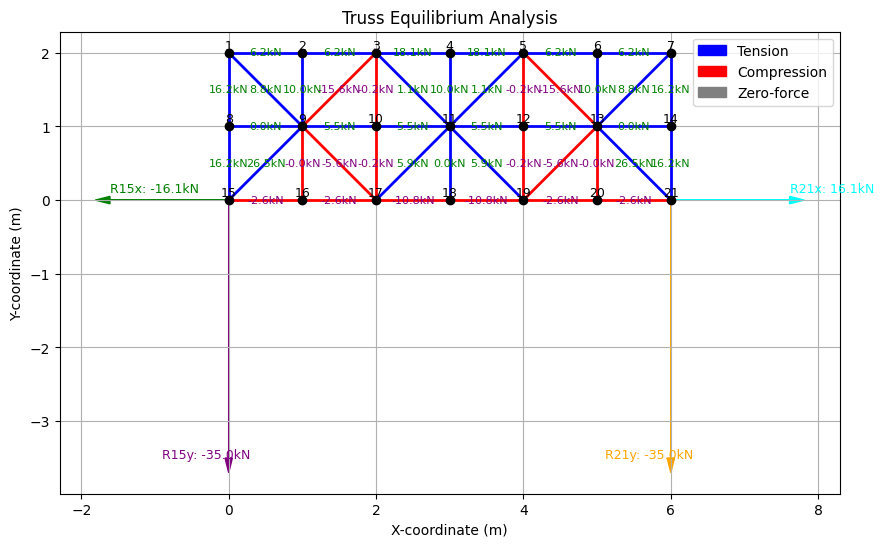

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 33: 8.819620 kN
  Member 34: -15.602465 kN
  Member 37: 1.133677 kN
  Member 38: 1.133677 kN
  Member 41: -15.602465 kN
  Member 42: 8.819620 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 379.685838 cubic units
Current Fixed Member Forces:
  Member 33: 1.381559 kN
  Member 34: -16.072915 kN
  Member 37: 0.925403 kN
  Member 38: 1.408768 kN
  Member 41: -25.800965 kN
  Member 42: 5.749492 kN
--------------------------------------------------
Generation 3: New Best Volume = 377.628653 cubic units
Current Fixed Member Forces:
  Member 33: 1.835769 kN
  Member 34: -24.015072 kN
  Member 37: 2.267353 kN
  Member 38: 2.267353 kN
  Member 41: -18.435695 kN
  Member 42: 0.000000 kN
--------------------------------------------------
Generation 11: New Best Volume = 376.862451 cubic units
Current Fixed Member Forces:
  Member 33: 2.313818 kN
  Member 34: -24.015072 

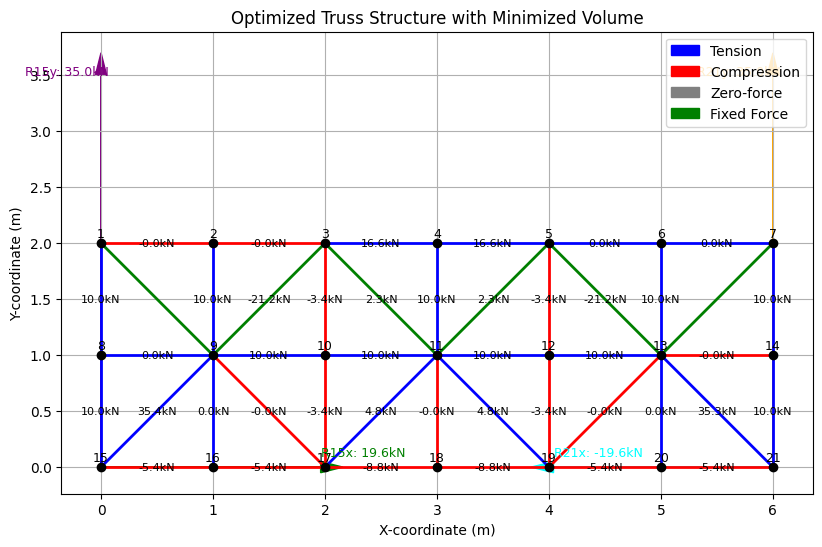

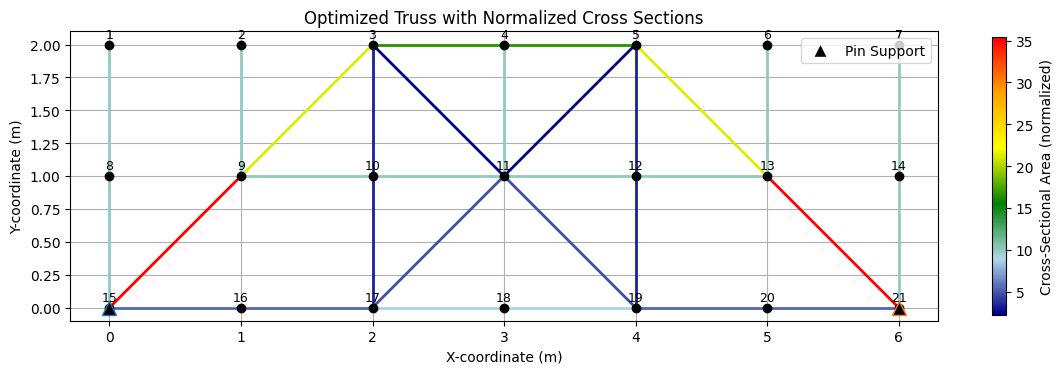

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [33, 34, 37, 38, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                A[eq_x, reaction_indices['R21x']] += 1   # R21x
                A[eq_y, reaction_indices['R21y']] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal)
        if reaction_forces[reaction_indices['R21x']] != 0:
            plt.arrow(x21, y21, reaction_forces[reaction_indices['R21x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + reaction_forces[reaction_indices['R21x']]/10, y21 + 0.1,
                     f"R21x: {reaction_forces[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal)
    if reaction_forces_ga[reaction_indices['R21x']] != 0:
        plt.arrow(x21, y21, reaction_forces_ga[reaction_indices['R21x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + reaction_forces_ga[reaction_indices['R21x']]/10, y21 + 0.1,
                 f"R21x: {reaction_forces_ga[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=200,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Test 2 - GA but with different member combination

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             6.236413      Tension        
Member 2     2             3             6.236413      Tension        
Member 3     3             4             18.070652     Tension        
Member 4     4             5             18.070652     Tension        
Member 5     5             6             6.236413      Tension        
Member 6     6             7             6.236413      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            5.461957      Tension        
Member 9     10            11            5.461957      Tension        
Member 10    11            12            5.461957      Tension        
Member 11    12      

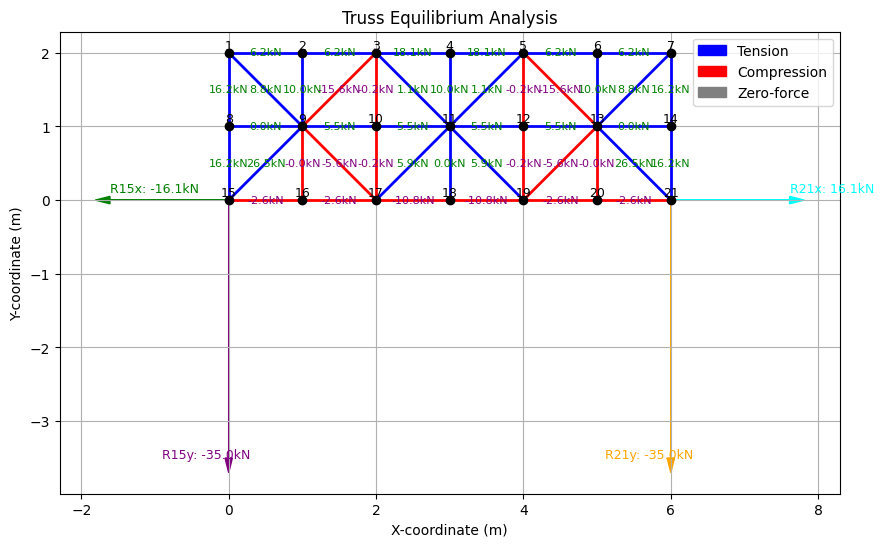

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 3: 18.070652 kN
  Member 4: 18.070652 kN
  Member 33: 8.819620 kN
  Member 34: -15.602465 kN
  Member 41: -15.602465 kN
  Member 42: 8.819620 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 400.695253 cubic units
Current Fixed Member Forces:
  Member 3: 23.109860 kN
  Member 4: 22.331187 kN
  Member 33: 7.340565 kN
  Member 34: -21.111393 kN
  Member 41: -25.865015 kN
  Member 42: 4.409979 kN
--------------------------------------------------
Generation 2: New Best Volume = 384.211069 cubic units
Current Fixed Member Forces:
  Member 3: 18.559553 kN
  Member 4: 20.663557 kN
  Member 33: 0.000000 kN
  Member 34: -21.396190 kN
  Member 41: -17.949793 kN
  Member 42: 11.196153 kN
--------------------------------------------------
Generation 6: New Best Volume = 382.015697 cubic units
Current Fixed Member Forces:
  Member 3: 19.233701 kN
  Member 4: 16.319437 kN

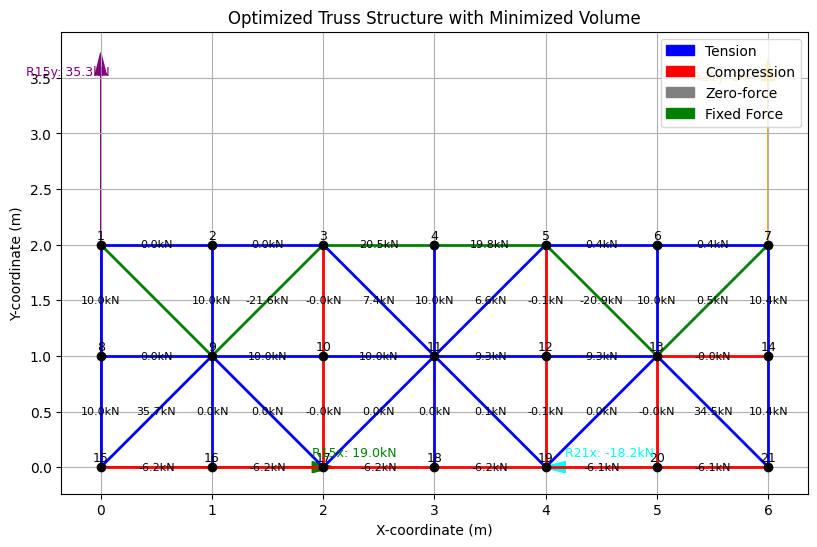

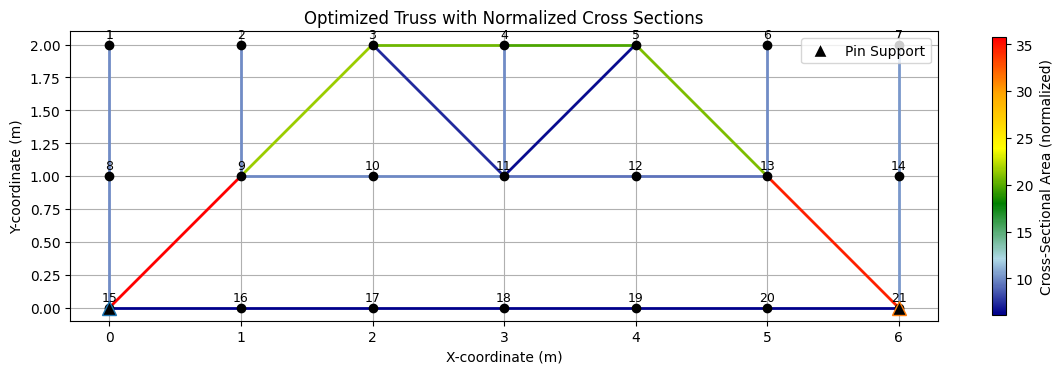

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [3, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                A[eq_x, reaction_indices['R21x']] += 1   # R21x
                A[eq_y, reaction_indices['R21y']] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal)
        if reaction_forces[reaction_indices['R21x']] != 0:
            plt.arrow(x21, y21, reaction_forces[reaction_indices['R21x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + reaction_forces[reaction_indices['R21x']]/10, y21 + 0.1,
                     f"R21x: {reaction_forces[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal)
    if reaction_forces_ga[reaction_indices['R21x']] != 0:
        plt.arrow(x21, y21, reaction_forces_ga[reaction_indices['R21x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + reaction_forces_ga[reaction_indices['R21x']]/10, y21 + 0.1,
                 f"R21x: {reaction_forces_ga[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=200,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Grouping the fixed force members - speeds up optimisation but still leaves "tie" in place

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             6.236413      Tension        
Member 2     2             3             6.236413      Tension        
Member 3     3             4             18.070652     Tension        
Member 4     4             5             18.070652     Tension        
Member 5     5             6             6.236413      Tension        
Member 6     6             7             6.236413      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            5.461957      Tension        
Member 9     10            11            5.461957      Tension        
Member 10    11            12            5.461957      Tension        
Member 11    12      

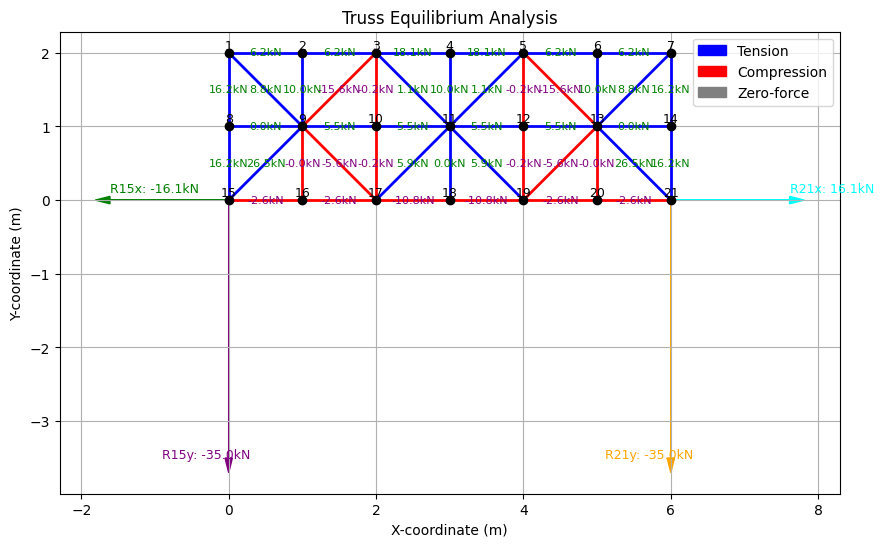

Degree of Indeterminacy: 6

Error: Number of specified fixed member groups (3) does not match the degree of indeterminacy (6).
--- Genetic Algorithm Optimization ---

Selected Fixed Member Groups (Total 6):
  Members [3, 4]: 18.070652 kN
  Members [33, 42]: 8.819620 kN
  Members [34, 41]: -15.602465 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 379.814429 cubic units
Current Fixed Member Forces:
  Members [3, 4]: 15.987842 kN
  Members [33, 42]: 1.076704 kN
  Members [34, 41]: -19.430552 kN
--------------------------------------------------
Generation 2: New Best Volume = 369.577292 cubic units
Current Fixed Member Forces:
  Members [3, 4]: 19.169083 kN
  Members [33, 42]: 0.000000 kN
  Members [34, 41]: -20.657194 kN
--------------------------------------------------
Generation 18: New Best Volume = 368.687375 cubic units
Current Fixed Member Forces:
  Members [3, 4]: 19.525050 kN
  Members [33, 42]: 0.000000 kN
  Members [34, 41]: -20.987768 kN
------------------

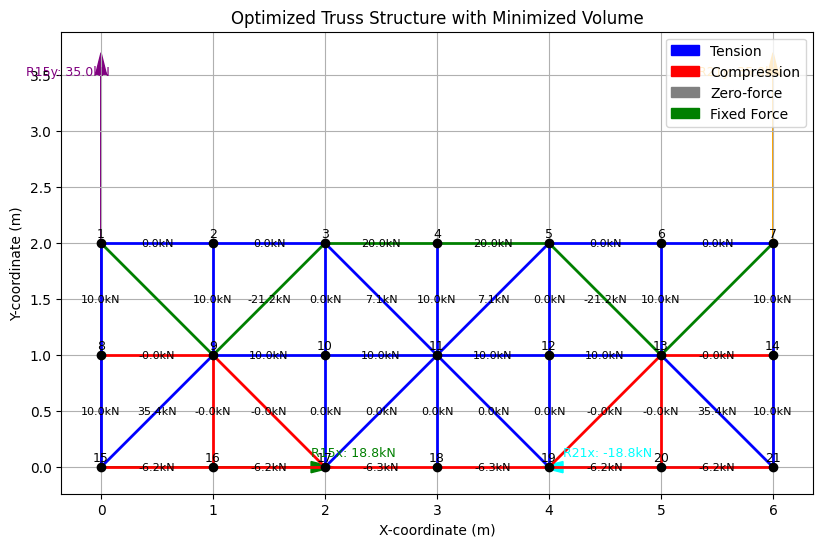

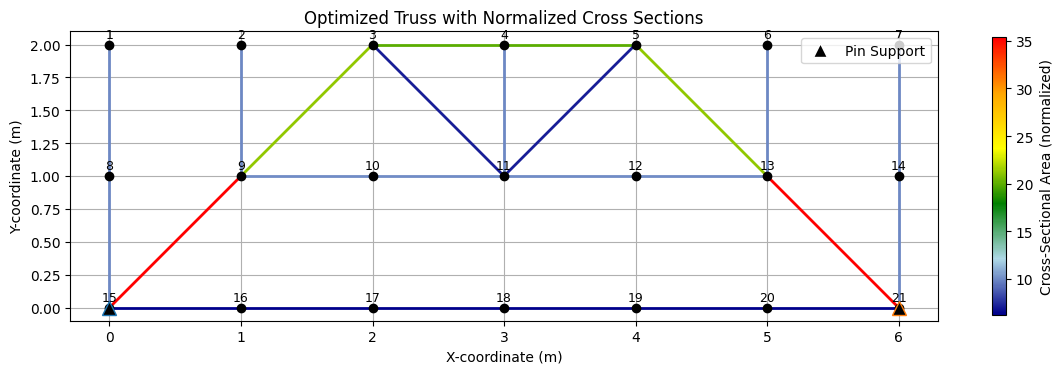

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFY_FIXED_MEMBER_GROUPS = True  # Set to True to specify fixed member groups manually
SPECIFIED_FIXED_MEMBER_IDS = [3, 4, 33, 34, 41, 42]  # List of member IDs to fix
FIXED_MEMBER_GROUPS = [[3, 4], [33, 42], [34, 41]]  # Member groups to be optimized together

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                A[eq_x, reaction_indices['R21x']] += 1   # R21x
                A[eq_y, reaction_indices['R21y']] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal)
        if reaction_forces[reaction_indices['R21x']] != 0:
            plt.arrow(x21, y21, reaction_forces[reaction_indices['R21x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + reaction_forces[reaction_indices['R21x']]/10, y21 + 0.1,
                     f"R21x: {reaction_forces[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_groups, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_groups = seed_fixed_member_groups
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = []
        for group in seed_fixed_member_groups:
            for m_id in group:
                self.fixed_member_indices.append(m_id - 1)

        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for m_id in current_fixed_member_forces:
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {}
        for group_idx, group in enumerate(self.seed_fixed_member_groups):
            force_value = individual[group_idx]
            for m_id in group:
                current_fixed_member_forces[m_id] = force_value
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, group in enumerate(self.seed_fixed_member_groups):
                    print(f"  Members {group}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_groups=[[m_id] for m_id in optimized_fixed_member_forces.keys()],
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for m_id in optimized_fixed_member_forces:
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimized_fixed_member_forces:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal)
    if reaction_forces_ga[reaction_indices['R21x']] != 0:
        plt.arrow(x21, y21, reaction_forces_ga[reaction_indices['R21x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + reaction_forces_ga[reaction_indices['R21x']]/10, y21 + 0.1,
                 f"R21x: {reaction_forces_ga[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_groups=[[m_id] for m_id in optimized_fixed_member_forces.keys()],
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for m_id in optimized_fixed_member_forces:
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if SPECIFY_FIXED_MEMBER_GROUPS:
            fixed_member_groups = FIXED_MEMBER_GROUPS
            num_groups = len(fixed_member_groups)
            if num_groups != N:
                print(f"Error: Number of specified fixed member groups ({num_groups}) does not match the degree of indeterminacy ({N}).")
                exit(1)
            # Get all fixed member IDs
            fixed_member_ids = [m_id for group in fixed_member_groups for m_id in group]
        else:
            if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
                print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
                exit(1)
            fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
            fixed_member_groups = [[m_id] for m_id in fixed_member_ids]
    else:
        # Code to select random fixed members
        pass

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed member groups
    seed_fixed_forces = {}
    for idx, group in enumerate(fixed_member_groups):
        group_forces = [member_forces[m_id - 1] for m_id in group]
        avg_force = sum(group_forces) / len(group_forces)
        seed_fixed_forces[idx] = avg_force  # Use group index as key

    # Print selected fixed member groups and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Member Groups (Total {N}):")
    for idx, group in enumerate(fixed_member_groups):
        print(f"  Members {group}: {seed_fixed_forces[idx]:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_groups=fixed_member_groups,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=200,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {}
    for idx, group in enumerate(fixed_member_groups):
        force_value = best_individual[idx]
        for m_id in group:
            optimized_fixed_member_forces[m_id] = force_value

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for idx, group in enumerate(fixed_member_groups):
        print(f"  Members {group}: {best_individual[idx]:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Setting the horizontal reaction forces to be equal and opposite one another

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             5.801587      Tension        
Member 2     2             3             5.801587      Tension        
Member 3     3             4             17.507937     Tension        
Member 4     4             5             17.507937     Tension        
Member 5     5             6             5.801587      Tension        
Member 6     6             7             5.801587      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            6.126984      Tension        
Member 9     10            11            6.126984      Tension        
Member 10    11            12            6.126984      Tension        
Member 11    12      

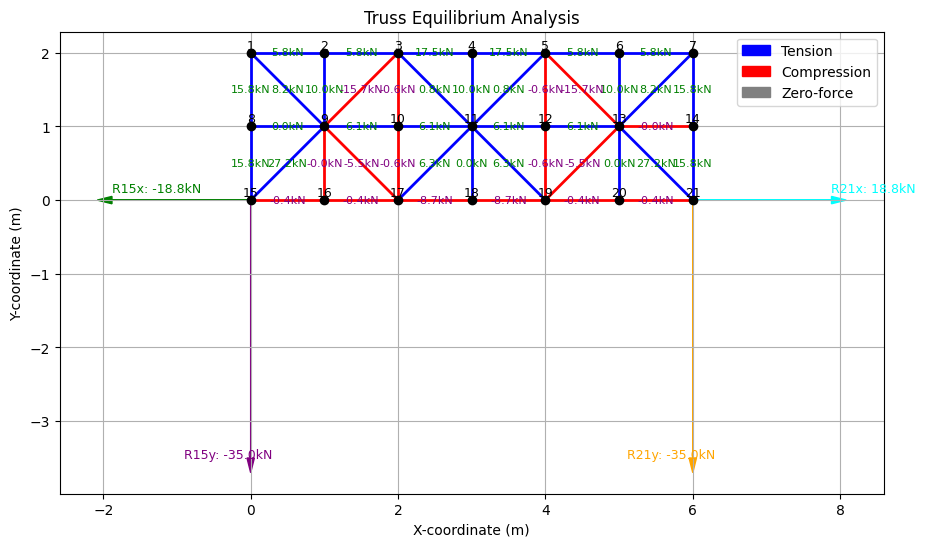

Degree of Indeterminacy: 5

Error: Number of specified fixed members (6) does not match the degree of indeterminacy (5).
--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 3: 17.507937 kN
  Member 4: 17.507937 kN
  Member 33: 8.204683 kN
  Member 34: -15.747156 kN
  Member 41: -15.747156 kN
  Member 42: 8.204683 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 395.777218 cubic units
Current Fixed Member Forces:
  Member 3: 21.106607 kN
  Member 4: 12.873241 kN
  Member 33: 4.271131 kN
  Member 34: -17.884726 kN
  Member 41: -21.151527 kN
  Member 42: 4.022097 kN
--------------------------------------------------
Generation 2: New Best Volume = 384.646002 cubic units
Current Fixed Member Forces:
  Member 3: 11.947211 kN
  Member 4: 27.159776 kN
  Member 33: 0.000000 kN
  Member 34: -21.832231 kN
  Member 41: -27.599610 kN
  Member 42: 1.206884 kN
--------------------------------------------------
Generation 3: New Best Volume = 364.33579

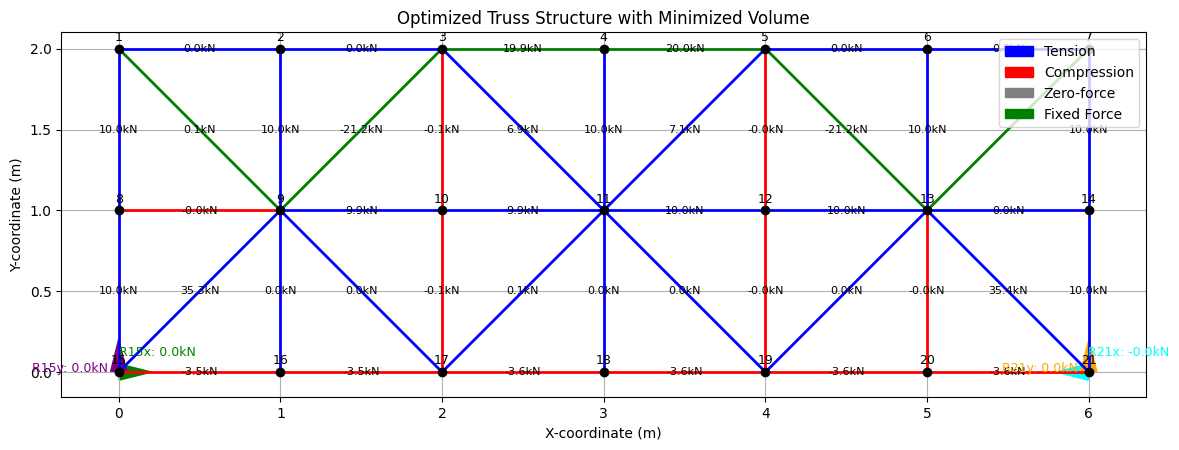

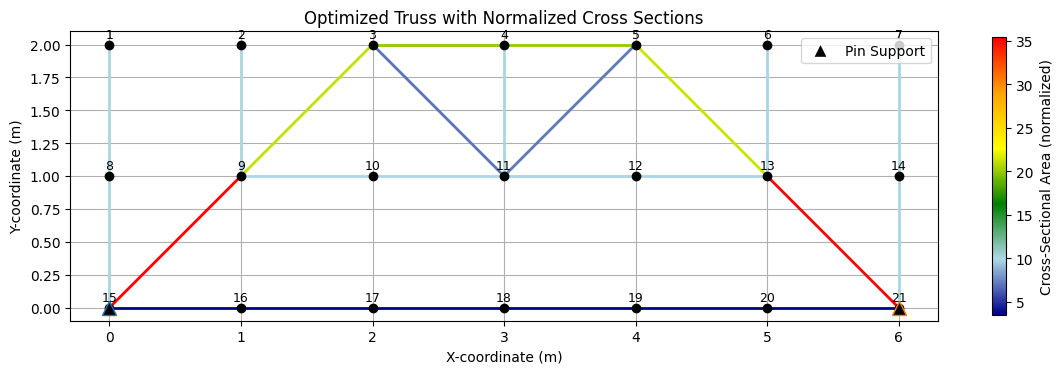

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [3, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
            # Note: 'R21x' is removed to enforce R21x = -R15x
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions  # Note: 'R21x' is removed

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                # Enforce R21x = -R15x by substituting in the equilibrium equation
                A[eq_x, reaction_indices['R15x']] += -1   # -R15x instead of R21x
                A[eq_y, reaction_indices['R21y']] += 1    # R21y remains independent

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Calculate and print R21x as -R15x
        R15x = reaction_forces[0]  # Assuming 'R15x' is the first reaction
        R21x = -R15x
        print(f"R21x: {R21x:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal) = -R15x
        R15x = reaction_forces[reaction_indices['R15x']]
        R21x = -R15x
        if R21x != 0:
            plt.arrow(x21, y21, R21x/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + R21x/10, y21 + 0.1,
                     f"R21x: {R21x:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                # Enforce R21x = -R15x by substituting in the equilibrium equation
                A_ga[eq_x, reaction_indices['R15x']] += 1    # R21x = -R15x, so +1 * R15x
                A_ga[eq_y, reaction_indices['R21y']] -= 1    # R21y remains independent

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[:num_reactions]  # Adjusted indexing

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal) = -R15x
    R15x = reaction_forces_ga[reaction_indices['R15x']]
    R21x = -R15x
    if R21x != 0:
        plt.arrow(x21, y21, R21x/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + R21x/10, y21 + 0.1,
                 f"R21x: {R21x:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Fixed Force Members = [4, 15, 33, 34, 41, 42] - structure finds optimum solution

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             5.801587      Tension        
Member 2     2             3             5.801587      Tension        
Member 3     3             4             17.507937     Tension        
Member 4     4             5             17.507937     Tension        
Member 5     5             6             5.801587      Tension        
Member 6     6             7             5.801587      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            6.126984      Tension        
Member 9     10            11            6.126984      Tension        
Member 10    11            12            6.126984      Tension        
Member 11    12      

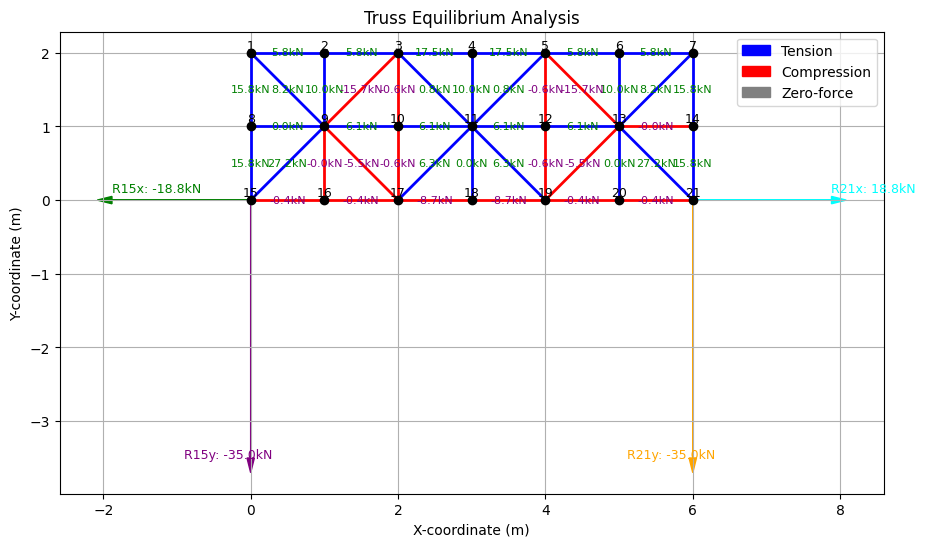

Degree of Indeterminacy: 5

Error: Number of specified fixed members (6) does not match the degree of indeterminacy (5).
--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 15: -8.666667 kN
  Member 4: 17.507937 kN
  Member 33: 8.204683 kN
  Member 34: -15.747156 kN
  Member 41: -15.747156 kN
  Member 42: 8.204683 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 407.825803 cubic units
Current Fixed Member Forces:
  Member 15: -6.722919 kN
  Member 4: 15.669654 kN
  Member 33: 6.871171 kN
  Member 34: -10.563752 kN
  Member 41: -19.932828 kN
  Member 42: 5.067944 kN
--------------------------------------------------
Generation 2: New Best Volume = 397.503254 cubic units
Current Fixed Member Forces:
  Member 15: -6.268890 kN
  Member 4: 18.746457 kN
  Member 33: 0.000000 kN
  Member 34: -27.363169 kN
  Member 41: -25.665632 kN
  Member 42: 0.000000 kN
--------------------------------------------------
Generation 3: New Best Volume = 375.77

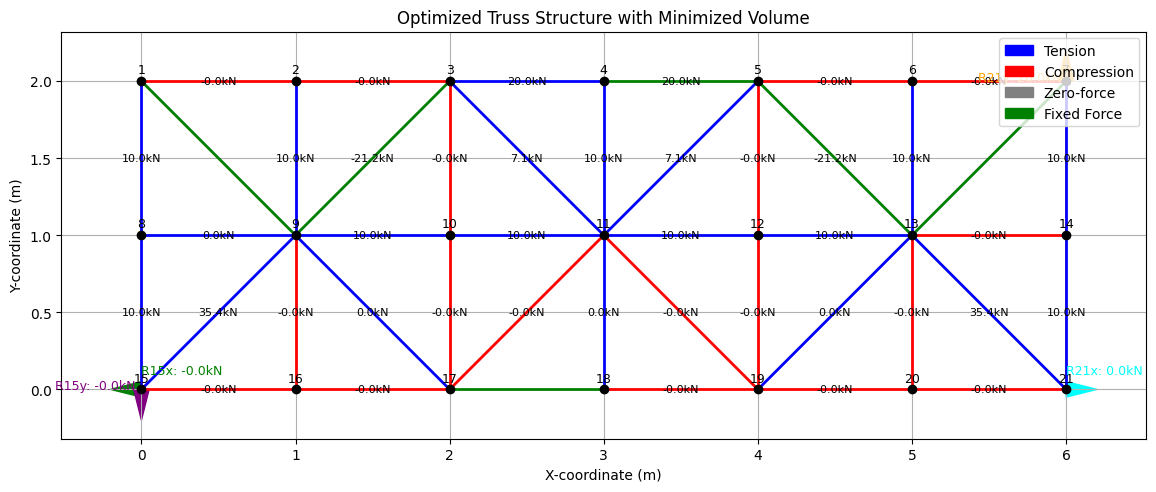

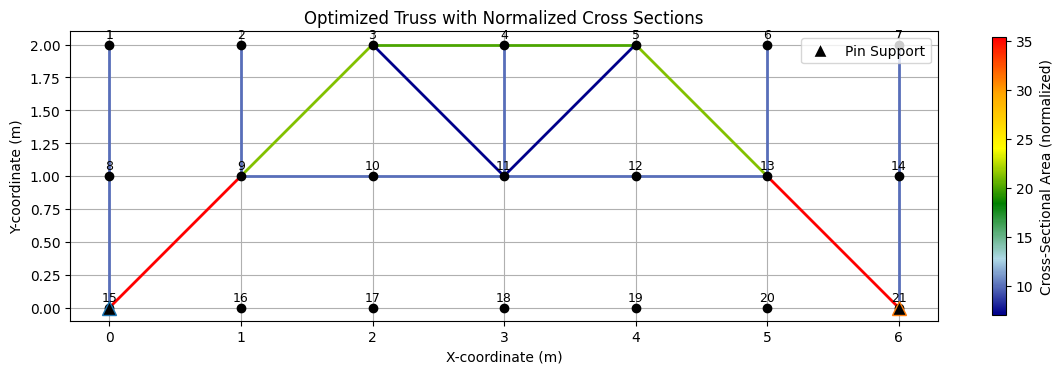

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [15, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
            # Note: 'R21x' is removed to enforce R21x = -R15x
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions  # Note: 'R21x' is removed

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                # Enforce R21x = -R15x by substituting in the equilibrium equation
                A[eq_x, reaction_indices['R15x']] += -1   # -R15x instead of R21x
                A[eq_y, reaction_indices['R21y']] += 1    # R21y remains independent

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Calculate and print R21x as -R15x
        R15x = reaction_forces[0]  # Assuming 'R15x' is the first reaction
        R21x = -R15x
        print(f"R21x: {R21x:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal) = -R15x
        R15x = reaction_forces[reaction_indices['R15x']]
        R21x = -R15x
        if R21x != 0:
            plt.arrow(x21, y21, R21x/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + R21x/10, y21 + 0.1,
                     f"R21x: {R21x:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                # Enforce R21x = -R15x by substituting in the equilibrium equation
                A_ga[eq_x, reaction_indices['R15x']] += 1    # R21x = -R15x, so +1 * R15x
                A_ga[eq_y, reaction_indices['R21y']] -= 1    # R21y remains independent

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[:num_reactions]  # Adjusted indexing

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal) = -R15x
    R15x = reaction_forces_ga[reaction_indices['R15x']]
    R21x = -R15x
    if R21x != 0:
        plt.arrow(x21, y21, R21x/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + R21x/10, y21 + 0.1,
                 f"R21x: {R21x:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Re test without the horizontal reactions being set to one another - this does work

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             6.236413      Tension        
Member 2     2             3             6.236413      Tension        
Member 3     3             4             18.070652     Tension        
Member 4     4             5             18.070652     Tension        
Member 5     5             6             6.236413      Tension        
Member 6     6             7             6.236413      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            5.461957      Tension        
Member 9     10            11            5.461957      Tension        
Member 10    11            12            5.461957      Tension        
Member 11    12      

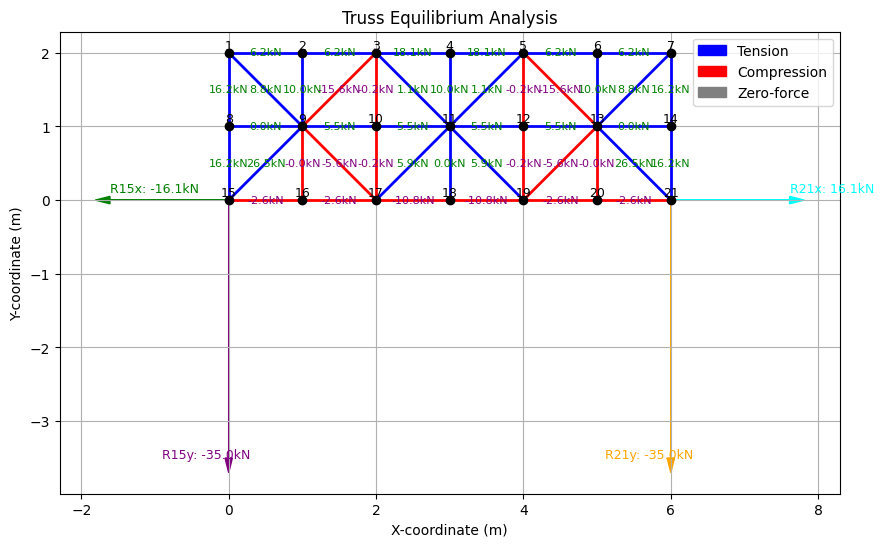

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 15: -10.815217 kN
  Member 4: 18.070652 kN
  Member 33: 8.819620 kN
  Member 34: -15.602465 kN
  Member 41: -15.602465 kN
  Member 42: 8.819620 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 397.757619 cubic units
Current Fixed Member Forces:
  Member 15: -6.577779 kN
  Member 4: 14.011814 kN
  Member 33: 1.440499 kN
  Member 34: -23.897817 kN
  Member 41: -13.850649 kN
  Member 42: 1.485720 kN
--------------------------------------------------
Generation 2: New Best Volume = 370.286116 cubic units
Current Fixed Member Forces:
  Member 15: -4.293914 kN
  Member 4: 16.626871 kN
  Member 33: 0.000000 kN
  Member 34: -25.013400 kN
  Member 41: -23.433242 kN
  Member 42: 0.000000 kN
--------------------------------------------------
Generation 3: New Best Volume = 353.531255 cubic units
Current Fixed Member Forces:
  Member 15: -3.999046 kN
  Member 4: 17.38875

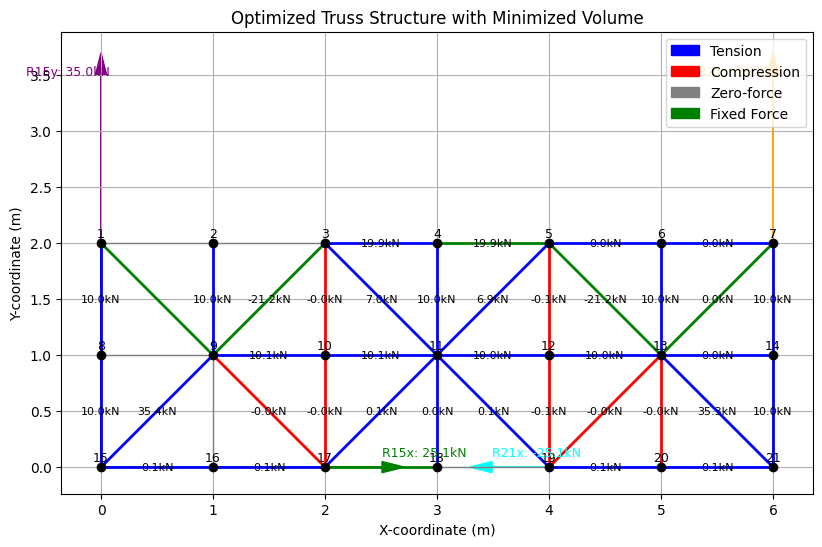

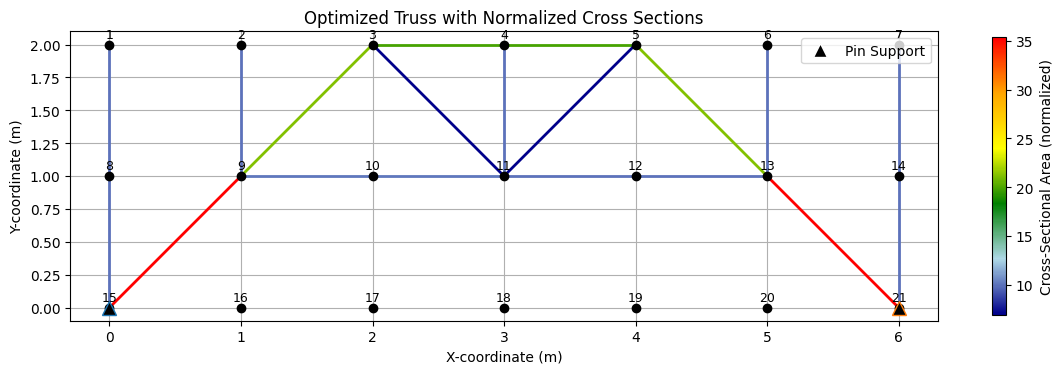

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [15, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = num_members + idx

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, reaction_indices['R15x']] += 1   # R15x
                A[eq_y, reaction_indices['R15y']] += 1   # R15y
            if node == 21:
                A[eq_x, reaction_indices['R21x']] += 1   # R21x
                A[eq_y, reaction_indices['R21y']] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Map reactions to indices
        reaction_indices = {}
        for idx, reaction in enumerate(self.support_reactions):
            reaction_indices[reaction] = idx

        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[reaction_indices['R15x']] != 0:
            plt.arrow(x15, y15, reaction_forces[reaction_indices['R15x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[reaction_indices['R15x']]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[reaction_indices['R15y']] != 0:
            plt.arrow(x15, y15, 0, reaction_forces[reaction_indices['R15y']]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[reaction_indices['R15y']]/10,
                     f"R15y: {reaction_forces[reaction_indices['R15y']]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Pin Support)
        x21, y21 = self.nodes[21]
        # Reaction R21x (Horizontal)
        if reaction_forces[reaction_indices['R21x']] != 0:
            plt.arrow(x21, y21, reaction_forces[reaction_indices['R21x']]/10, 0,
                      head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            plt.text(x21 + reaction_forces[reaction_indices['R21x']]/10, y21 + 0.1,
                     f"R21x: {reaction_forces[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
        # Reaction R21y (Vertical)
        if reaction_forces[reaction_indices['R21y']] != 0:
            plt.arrow(x21, y21, 0, reaction_forces[reaction_indices['R21y']]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 - 0.3, y21 + reaction_forces[reaction_indices['R21y']]/10,
                     f"R21y: {reaction_forces[reaction_indices['R21y']]:.1f}kN",
                     color='orange', fontsize=9, ha='center')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (±100% from seed or at least ±0.1)
        self.gene_bounds = []
        for force in self.seed_fixed_forces.values():
            delta = max(abs(force), 0.1)
            low = force - delta
            high = force + delta
            self.gene_bounds.append((low, high))

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[reaction_indices['R15x']] != 0:
        plt.arrow(x15, y15, reaction_forces_ga[reaction_indices['R15x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[reaction_indices['R15x']]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[reaction_indices['R15x']]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[reaction_indices['R15y']] != 0:
        plt.arrow(x15, y15, 0, reaction_forces_ga[reaction_indices['R15y']]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[reaction_indices['R15y']]/10,
                 f"R15y: {reaction_forces_ga[reaction_indices['R15y']]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21x (Horizontal)
    if reaction_forces_ga[reaction_indices['R21x']] != 0:
        plt.arrow(x21, y21, reaction_forces_ga[reaction_indices['R21x']]/10, 0,
                  head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
        plt.text(x21 + reaction_forces_ga[reaction_indices['R21x']]/10, y21 + 0.1,
                 f"R21x: {reaction_forces_ga[reaction_indices['R21x']]:.1f}kN", color='cyan', fontsize=9, ha='left')
    # Reaction R21y (Vertical)
    if reaction_forces_ga[reaction_indices['R21y']] != 0:
        plt.arrow(x21, y21, 0, reaction_forces_ga[reaction_indices['R21y']]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 - 0.3, y21 + reaction_forces_ga[reaction_indices['R21y']]/10,
                 f"R21y: {reaction_forces_ga[reaction_indices['R21y']]:.1f}kN",
                 color='orange', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=200,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Removing the first part of the code - so the code starts from a random values of fixed member forces

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 15: 0.492862 kN
  Member 4: 11.091378 kN
  Member 33: 43.046298 kN
  Member 34: 13.159458 kN
  Member 41: 22.496934 kN
  Member 42: 12.594148 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 616.069123 cubic units
Current Fixed Member Forces:
  Member 15: -5.672864 kN
  Member 4: 13.286393 kN
  Member 33: 10.130712 kN
  Member 34: -16.318463 kN
  Member 41: 10.324661 kN
  Member 42: 12.829078 kN
--------------------------------------------------
Generation 2: New Best Volume = 595.947147 cubic units
Current Fixed Member Forces:
  Member 15: -17.186821 kN
  Member 4: 13.583494 kN
  Member 33: -6.017544 kN
  Member 34: -25.249080 kN
  Member 41: -15.503818 kN
  Member 42: -11.758210 kN
--------------------------------------------------
Generation 3: New Best Volume = 549.563883 cubic units
Current Fixed

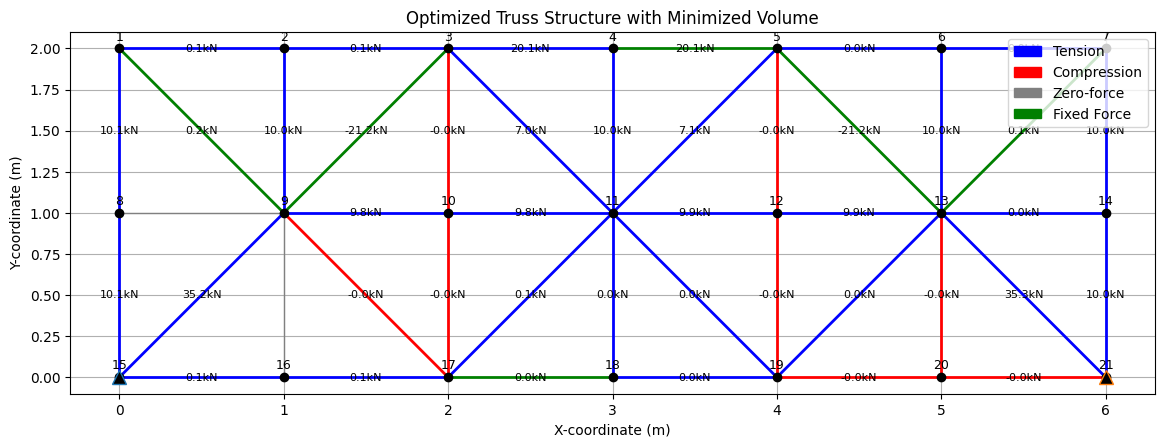

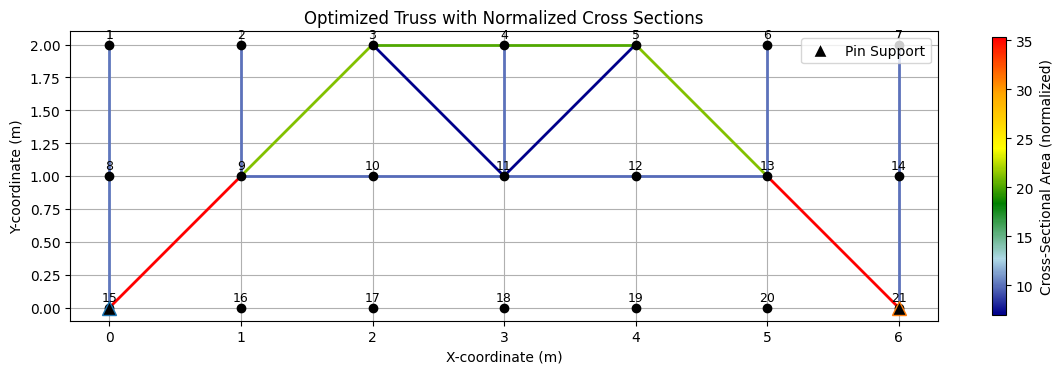

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [15, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (0 to 50)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between 0 and 50
    seed_fixed_forces = {m_id: random.uniform(0, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Update the Configuration settings

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 15: 45.397158 kN
  Member 4: 44.695109 kN
  Member 33: 34.582612 kN
  Member 34: -16.939176 kN
  Member 41: -49.796166 kN
  Member 42: 32.698115 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 639.240218 cubic units
Current Fixed Member Forces:
  Member 15: -4.457962 kN
  Member 4: 28.566362 kN
  Member 33: 37.483454 kN
  Member 34: -12.575862 kN
  Member 41: -21.678196 kN
  Member 42: 16.081563 kN
--------------------------------------------------
Generation 2: New Best Volume = 620.907321 cubic units
Current Fixed Member Forces:
  Member 15: -21.286623 kN
  Member 4: 28.566362 kN
  Member 33: 37.483454 kN
  Member 34: -1.789370 kN
  Member 41: -19.069094 kN
  Member 42: 16.081563 kN
--------------------------------------------------
Generation 3: New Best Volume = 542.604677 cubic units
Current Fix

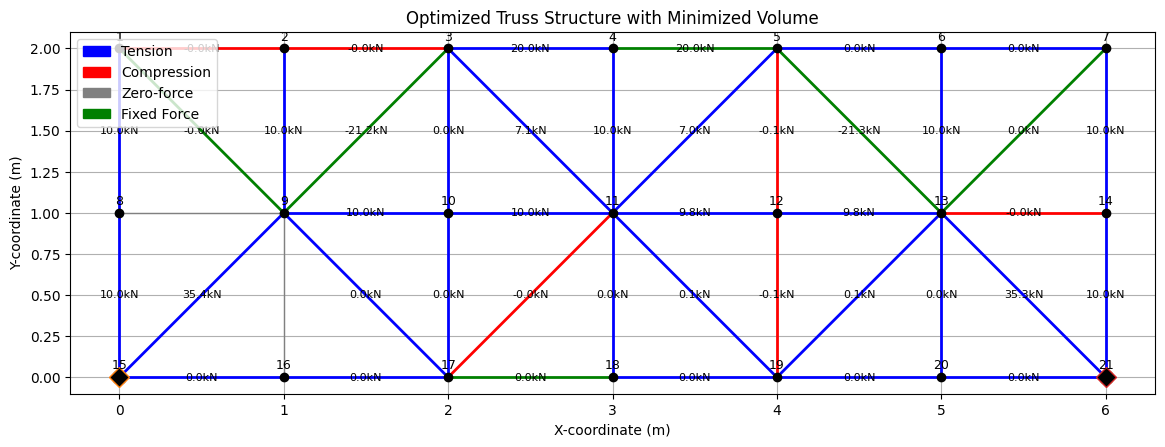

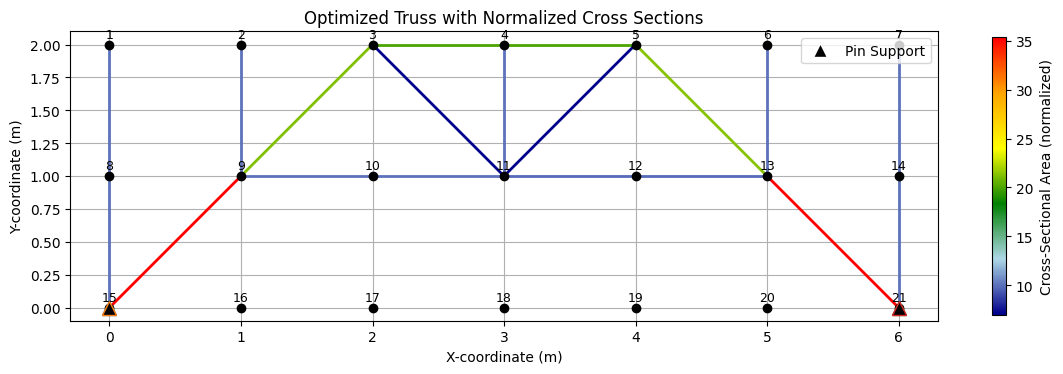

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

# General Truss Configuration
NUMBER_OF_COLUMNS = 7      # Number of nodes along the width (x-axis)
NUMBER_OF_ROWS = 3         # Number of nodes along the height (y-axis)
LOADS = {                  # External loads applied to specific nodes
    # node_id: [load_x, load_y]
    1: [0, -10],
    2: [0, -10],
    3: [0, -10],
    4: [0, -10],
    5: [0, -10],
    6: [0, -10],
    7: [0, -10],
}
SUPPORTS = {               # Support nodes and their restraints
    # node_id: [restraint_x, restraint_y]
    15: [1, 1],  # Node 15 is restrained in both x and y directions
    21: [1, 1],
}

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [15, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=NUMBER_OF_COLUMNS, rows=NUMBER_OF_ROWS, loads=LOADS, supports=SUPPORTS):
        self.columns = columns
        self.rows = rows
        self.loads = loads  # External loads: {node_id: [load_x, load_y], ...}
        self.supports = supports  # Supports: {node_id: [restraint_x, restraint_y], ...}
        self.nodes = {}
        self.members = {}
        self.support_reactions = {}  # To be populated based on supports
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.define_support_reactions()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=rows-1 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=columns-1
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            if middle_node <= len(self.nodes):
                self.add_member(top_node, middle_node)
            if bottom_node <= len(self.nodes):
                self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes (optional, can be configured)
        # For generality, you might want to make this configurable or algorithmic
        # Here, retaining the original diagonal definitions
        middle_nodes = [self.columns + 2, self.columns + 4, self.columns + 6]  # Adjusted for dynamic columns
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            if node not in self.nodes:
                continue
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Loads are already provided in the configuration as a dictionary
        self.external_loads = self.loads

    def define_support_reactions(self):
        # Initialize support reactions based on SUPPORTS configuration
        for node_id, restraints in self.supports.items():
            restraint_x, restraint_y = restraints
            if restraint_x:
                self.support_reactions[f'R{node_id}x'] = None  # Reaction in x-direction
            if restraint_y:
                self.support_reactions[f'R{node_id}y'] = None  # Reaction in y-direction

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (based on configuration, can be adjusted)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, [0, 0])
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            for reaction, idx in reaction_indices.items():
                # Extract node_id from reaction name e.g., 'R15x' -> 15
                reaction_node_id = int(''.join(filter(str.isdigit, reaction)))
                if node == reaction_node_id:
                    if 'x' in reaction:
                        A_ga[eq_x, reaction_indices[reaction]] -= 1   # Reaction in x
                    if 'y' in reaction:
                        A_ga[eq_y, reaction_indices[reaction]] -= 1   # Reaction in y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    for reaction in truss.support_reactions:
        # Extract node_id from reaction name e.g., 'R15x' -> 15
        reaction_node_id = int(''.join(filter(str.isdigit, reaction)))
        x, y = truss.nodes[reaction_node_id]
        if 'x' in reaction and 'y' in reaction:
            marker = 's'  # Square for fixed in both directions
            label = 'Fixed Support'
        elif 'x' in reaction:
            marker = 'o'  # Circle for fixed in x-direction
            label = 'Support X'
        elif 'y' in reaction:
            marker = 'D'  # Diamond for fixed in y-direction
            label = 'Support Y'
        else:
            marker = 'x'
            label = 'Support'

        plt.plot(x, y, marker=marker, markersize=10, markerfacecolor='black', label=label)

    # To avoid duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper left')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    for reaction in truss.support_reactions:
        # Extract node_id from reaction name e.g., 'R15x' -> 15
        reaction_node_id = int(''.join(filter(str.isdigit, reaction)))
        x, y = truss.nodes[reaction_node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss with new configurations
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between -50 and 50
    seed_fixed_forces = {m_id: random.uniform(-50, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")
